In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

import os

# Set working directory to your project root
os.chdir("C:/Users/nis03/recidivism-risk-prediction")

# Now this will work:
import pandas as pd
df = pd.read_csv("data/raw/Unfilterdata.csv")

# 1. Strip whitespace from column names
df.columns = df.columns.str.strip()

# 2. Drop duplicates if any
df.drop_duplicates(inplace=True)

# 3. Handle missing values
df['Race - Ethnicity'] = df['Race - Ethnicity'].fillna('Unknown')
df['Release Type'] = df['Release Type'].fillna('Unknown')
df['Main Supervising District'] = df['Main Supervising District'].fillna('Unknown')

# 4. Convert 'Age At Release' to numeric
age_map = {
    'Under 25': 22,
    '25-34': 29.5,
    '35-44': 39.5,
    '45-54': 49.5,
    '55 and Older': 60
}
df['Age At Release'] = df['Age At Release'].map(age_map)
df['Age At Release'] = df['Age At Release'].fillna(np.median(list(age_map.values())))

# 5. Encode categorical variables
categorical_cols = [
    'Race - Ethnicity',
    'Convicting Offense Classification',
    'Convicting Offense Type',
    'Convicting Offense Subtype',
    'Release Type',
    'Main Supervising District',
    'Part of Target Population'
]

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# 6. Standardize 'Age At Release'
scaler = StandardScaler()
df['Age At Release'] = scaler.fit_transform(df[['Age At Release']])

# Final check
print("Preprocessing complete. Final shape:", df.shape)
print("Missing values:\n", df.isnull().sum())


Preprocessing complete. Final shape: (14576, 12)
Missing values:
 Fiscal Year Released                           0
Recidivism Reporting Year                      0
Race - Ethnicity                               0
Age At Release                                 0
Convicting Offense Classification              0
Convicting Offense Type                        0
Convicting Offense Subtype                     0
Main Supervising District                      0
Release Type                                   0
Release type: Paroled to Detainder united    789
Part of Target Population                      0
Recidivism - Return to Prison numeric          0
dtype: int64


In [6]:
import datetime

# 1. Years Since Release (using current year dynamically)
current_year = datetime.datetime.now().year
df['Years Since Release'] = current_year - df['Fiscal Year Released']

# 2. Offense Severity Score
# Mapping offense classification to numeric severity
severity_map = {
    'A Felony': 5,
    'B Felony': 4,
    'C Felony': 3,
    'D Felony': 2,
    'Aggravated Misdemeanor': 1,
    'Serious Misdemeanor': 0.5,
    'Simple Misdemeanor': 0.25
}

# Map offense severity and handle missing/unmapped values
df['Offense Severity'] = df['Convicting Offense Classification'].map(severity_map).fillna(0)

# 3. High-Risk District
# Calculate mean recidivism rate by district
district_recid_rate = df.groupby('Main Supervising District')['Recidivism - Return to Prison numeric'].mean()

# Identify high-risk districts (above average)
overall_mean_rate = district_recid_rate.mean()
high_risk_districts = district_recid_rate[district_recid_rate > overall_mean_rate].index

# Assign 1 if in high-risk district, else 0
df['High Risk District'] = df['Main Supervising District'].isin(high_risk_districts).astype(int)


In [7]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['Recidivism - Return to Prison numeric'])
y = df['Recidivism - Return to Prison numeric']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [8]:
print(X_train.dtypes)


Fiscal Year Released                           int64
Recidivism Reporting Year                      int64
Race - Ethnicity                               int32
Age At Release                               float64
Convicting Offense Classification              int32
Convicting Offense Type                        int32
Convicting Offense Subtype                     int32
Main Supervising District                      int32
Release Type                                   int32
Release type: Paroled to Detainder united     object
Part of Target Population                      int32
Years Since Release                            int64
Offense Severity                             float64
High Risk District                             int32
dtype: object


In [9]:
# ---------------------------------------------
# 1. Define Features and Target (Drop Problem Column)
# ---------------------------------------------

# Drop 'Release type: Paroled to Detainder united' because it's object type (string)
X = df.drop(columns=['Recidivism - Return to Prison numeric', 'Release type: Paroled to Detainder united'])
y = df['Recidivism - Return to Prison numeric']

# ---------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# ---------------------------------------------
# 3. Handle Class Imbalance with SMOTE
# ---------------------------------------------

from imblearn.over_sampling import SMOTE

# Create SMOTE instance
sm = SMOTE(random_state=42)

# Apply SMOTE only on training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# ---------------------------------------------
# 4. (Optional) Check class distribution after SMOTE
# ---------------------------------------------

print("After SMOTE:")
print(y_train_res.value_counts())


After SMOTE:
Recidivism - Return to Prison numeric
1    7365
0    7365
Name: count, dtype: int64


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
logreg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
logreg.fit(X_train_res, y_train_res)
y_pred_log = logreg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)


In [11]:
from xgboost import XGBClassifier

# Define model
xgb = XGBClassifier(
    eval_metric='logloss', 
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), 
    random_state=42
)

# Train model
xgb.fit(X_train_res, y_train_res)

# Predict
y_pred_xgb = xgb.predict(X_test)


In [12]:
# ERROR ANALYSIS for XGBoost misclassifications
import pandas as pd

# Copy test features and attach prediction results
X_test_analysis = X_test.copy()
X_test_analysis['Actual'] = y_test
X_test_analysis['Predicted'] = y_pred_xgb
X_test_analysis['Correct'] = X_test_analysis['Actual'] == X_test_analysis['Predicted']

# Identify misclassified cases
false_negatives = X_test_analysis[(X_test_analysis['Actual'] == 1) & (X_test_analysis['Predicted'] == 0)]
false_positives = X_test_analysis[(X_test_analysis['Actual'] == 0) & (X_test_analysis['Predicted'] == 1)]

# Summary stats for misclassified cases
print("False Negatives (Actual = 1, Predicted = 0):", false_negatives.shape[0])
print("False Positives (Actual = 0, Predicted = 1):", false_positives.shape[0])

# Explore patterns in misclassifications
print("\nTop Districts in False Negatives:")
print(false_negatives['Main Supervising District'].value_counts().head())

print("\nAge Summary in False Negatives:")
print(false_negatives['Age At Release'].describe())

print("\nTop Offense Types in False Positives:")
print(false_positives['Convicting Offense Type'].value_counts().head())


False Negatives (Actual = 1, Predicted = 0): 338
False Positives (Actual = 0, Predicted = 1): 967

Top Districts in False Negatives:
Main Supervising District
10    126
4      39
2      34
0      29
1      27
Name: count, dtype: int64

Age Summary in False Negatives:
count    338.000000
mean       0.118848
std        1.052702
min       -1.266533
25%       -0.596251
50%        0.297457
75%        1.191166
max        2.129560
Name: Age At Release, dtype: float64

Top Offense Types in False Positives:
Convicting Offense Type
2    328
0    264
4    176
3    137
1     62
Name: count, dtype: int64


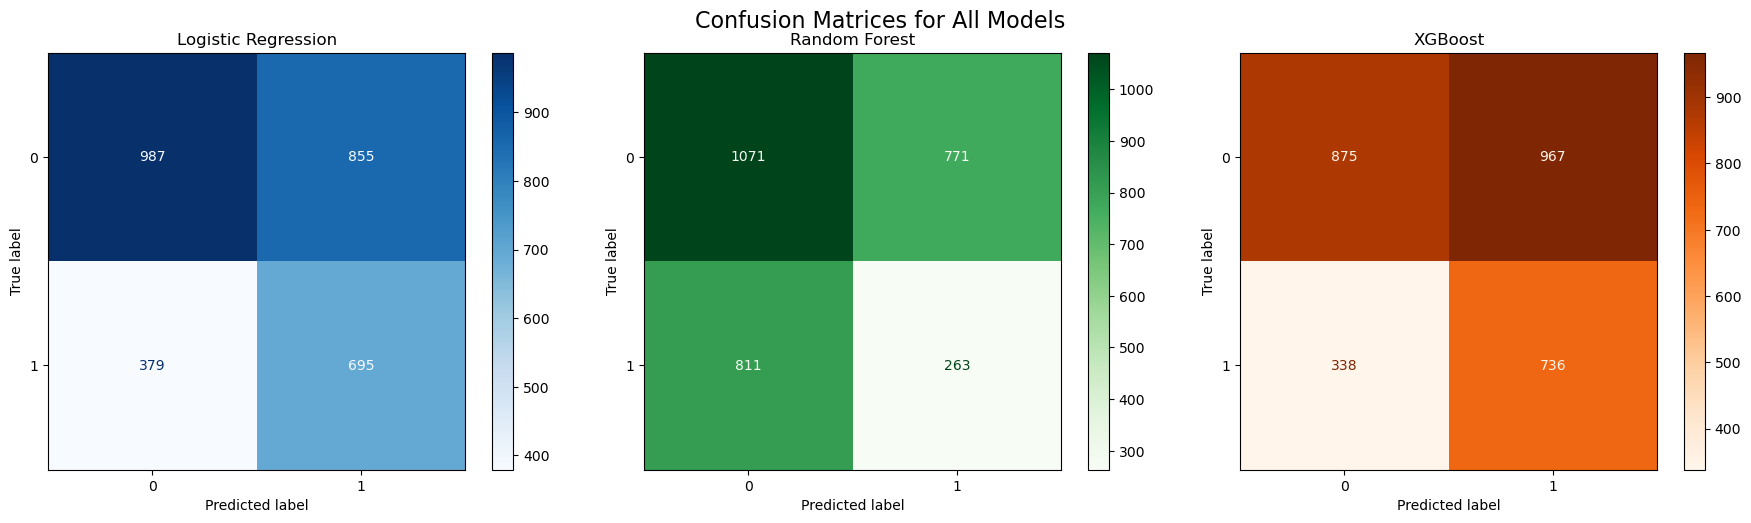

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')

# Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1], cmap='Greens')
axes[1].set_title('Random Forest')

# XGBoost
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=axes[2], cmap='Oranges')
axes[2].set_title('XGBoost')

plt.suptitle('Confusion Matrices for All Models', fontsize=16)
plt.tight_layout()
plt.show()


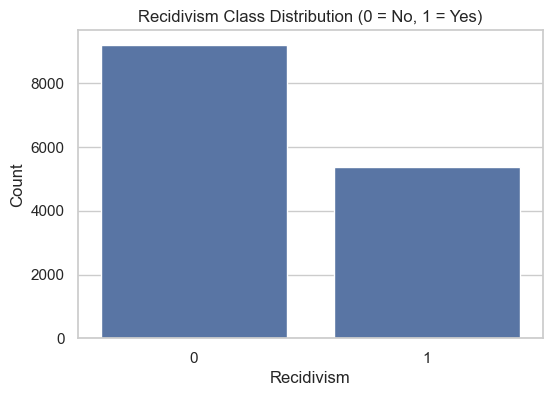

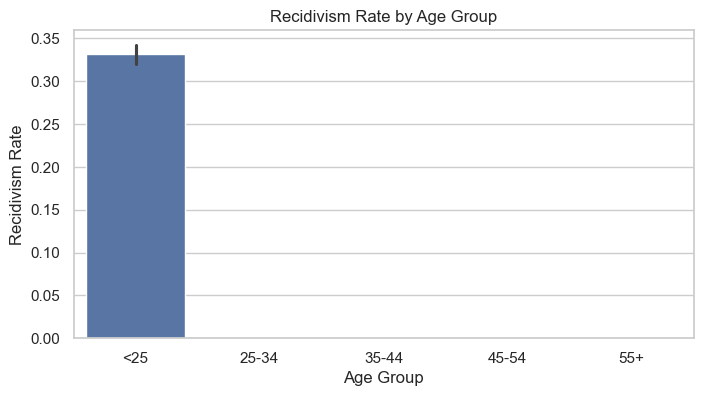

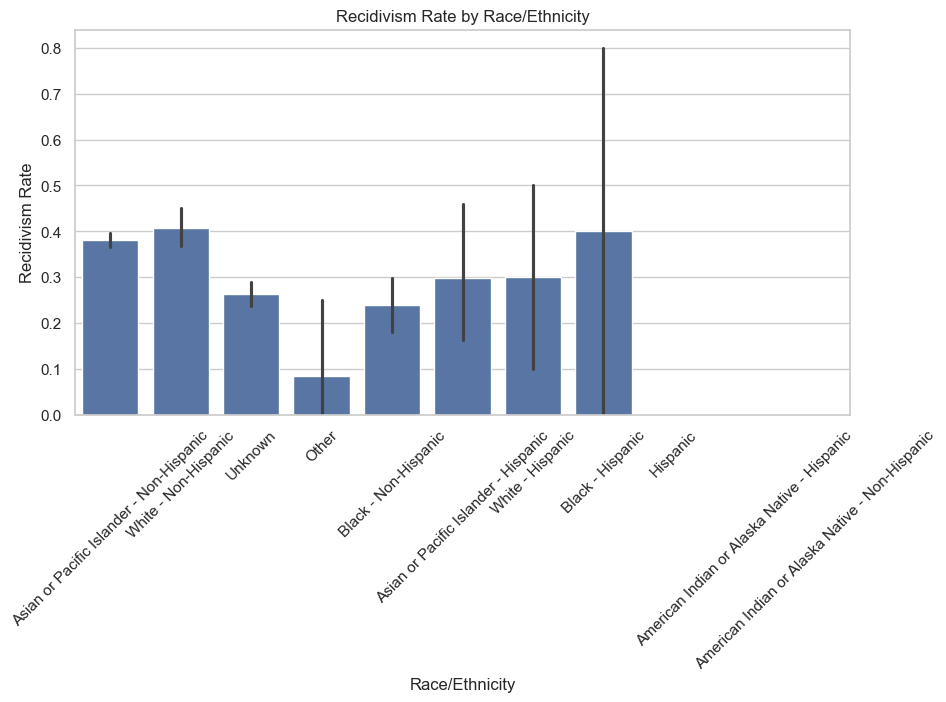

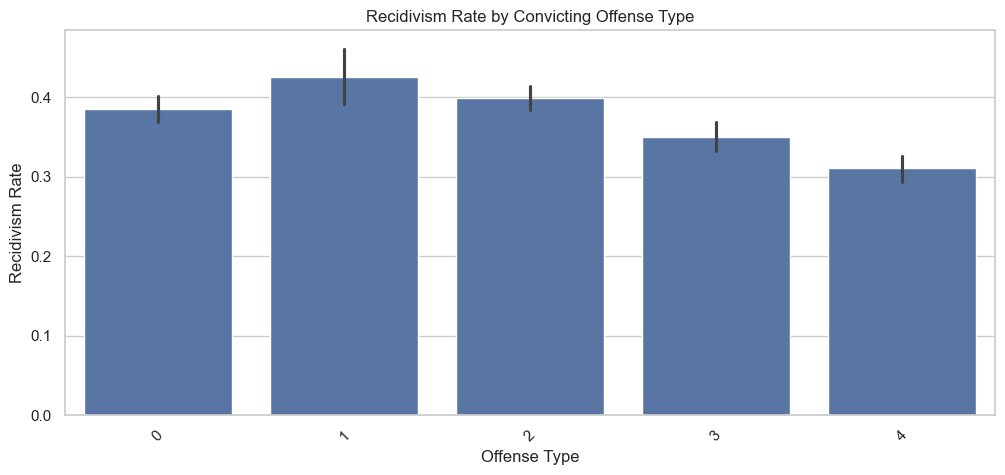

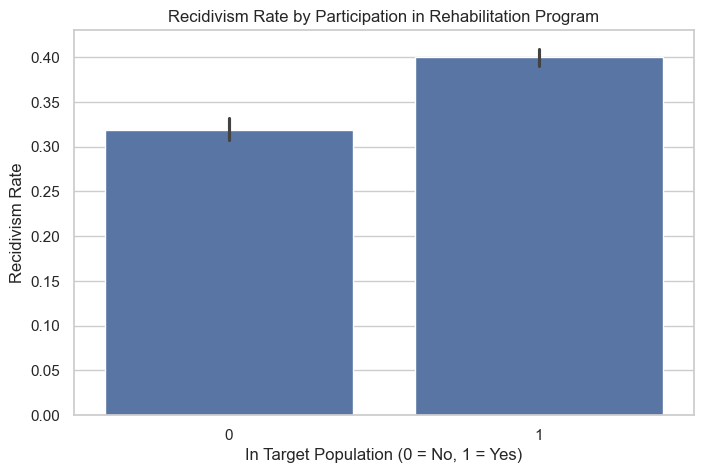

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn plot style
sns.set(style="whitegrid")

# 1. Recidivism Class Distribution (Class Imbalance Check)
plt.figure(figsize=(6,4))
sns.countplot(x='Recidivism - Return to Prison numeric', data=df)
plt.title('Recidivism Class Distribution (0 = No, 1 = Yes)')
plt.xlabel('Recidivism')
plt.ylabel('Count')
plt.show()

# 2. Recidivism Rate by Age Group
# (using unscaled version to make Age Buckets)
df_age_plot = df.copy()

# Re-scale Age to original before binning
df_age_plot['Age Bucket'] = pd.cut(
    df_age_plot['Age At Release'] * df_age_plot['Age At Release'].std() + df_age_plot['Age At Release'].mean(),
    bins=[0, 25, 35, 45, 55, 100],
    labels=['<25', '25-34', '35-44', '45-54', '55+']
)

plt.figure(figsize=(8,4))
sns.barplot(x='Age Bucket', y='Recidivism - Return to Prison numeric', data=df_age_plot)
plt.title('Recidivism Rate by Age Group')
plt.ylabel('Recidivism Rate')
plt.xlabel('Age Group')
plt.show()

# 3. Recidivism Rate by Race/Ethnicity
# Correct Race Mapping
race_mapping = {
    0: 'White - Hispanic',
    1: 'White - Non-Hispanic',
    2: 'Black - Hispanic',
    3: 'Black - Non-Hispanic',
    4: 'Hispanic',
    5: 'Asian or Pacific Islander - Hispanic',
    6: 'Asian or Pacific Islander - Non-Hispanic',
    7: 'American Indian or Alaska Native - Hispanic',
    8: 'American Indian or Alaska Native - Non-Hispanic',
    9: 'Other',
    10: 'Unknown'
}

# Apply mapping
df_race_plot = df.copy()
df_race_plot['Race - Ethnicity'] = df_race_plot['Race - Ethnicity'].map(race_mapping)

# Plot Recidivism by Race/Ethnicity
plt.figure(figsize=(10,5))
sns.barplot(x='Race - Ethnicity', y='Recidivism - Return to Prison numeric', data=df_race_plot)
plt.title('Recidivism Rate by Race/Ethnicity')
plt.xticks(rotation=45)
plt.ylabel('Recidivism Rate')
plt.xlabel('Race/Ethnicity')
plt.show()

# 4. Recidivism Rate by Convicting Offense Type
plt.figure(figsize=(12,5))
sns.barplot(x='Convicting Offense Type', y='Recidivism - Return to Prison numeric', data=df)
plt.title('Recidivism Rate by Convicting Offense Type')
plt.xticks(rotation=45)
plt.ylabel('Recidivism Rate')
plt.xlabel('Offense Type')
plt.show()

# 5. Recidivism Rate by Participation in Rehabilitation Program
plt.figure(figsize=(8,5))
sns.barplot(x='Part of Target Population', y='Recidivism - Return to Prison numeric', data=df)
plt.title('Recidivism Rate by Participation in Rehabilitation Program')
plt.ylabel('Recidivism Rate')
plt.xlabel('In Target Population (0 = No, 1 = Yes)')
plt.show()


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.576818   0.448387  0.647114  0.529726
1        Random Forest  0.457476   0.254352  0.244879  0.249526
2              XGBoost  0.552469   0.432179  0.685289  0.530068


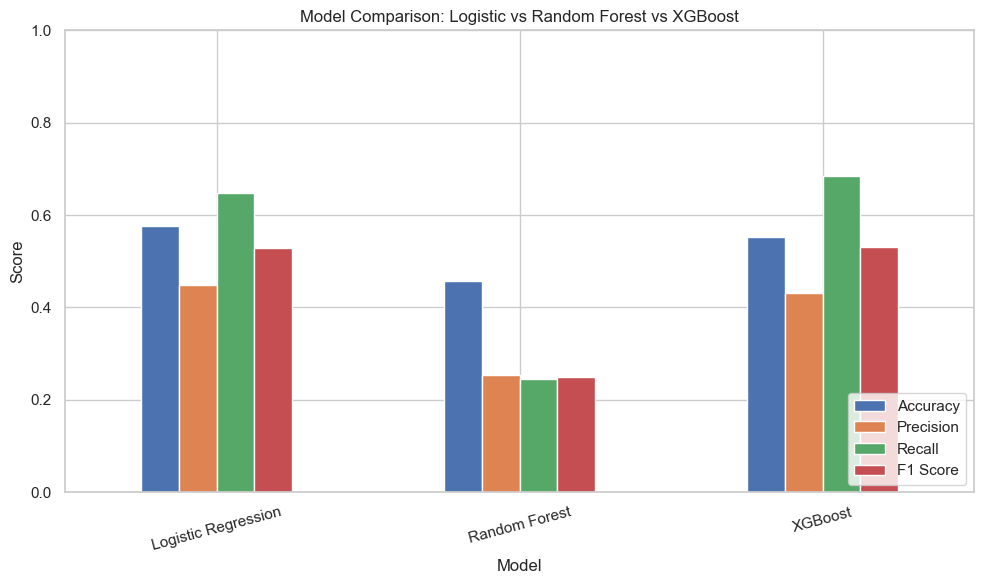

In [18]:
# Collect metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for model_name, y_pred in models.items():
    metrics["Model"].append(model_name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1 Score"].append(f1_score(y_test, y_pred))

metrics_df = pd.DataFrame(metrics)

# Display
print(metrics_df)

# Plot
metrics_df.set_index("Model").plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Logistic vs Random Forest vs XGBoost")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


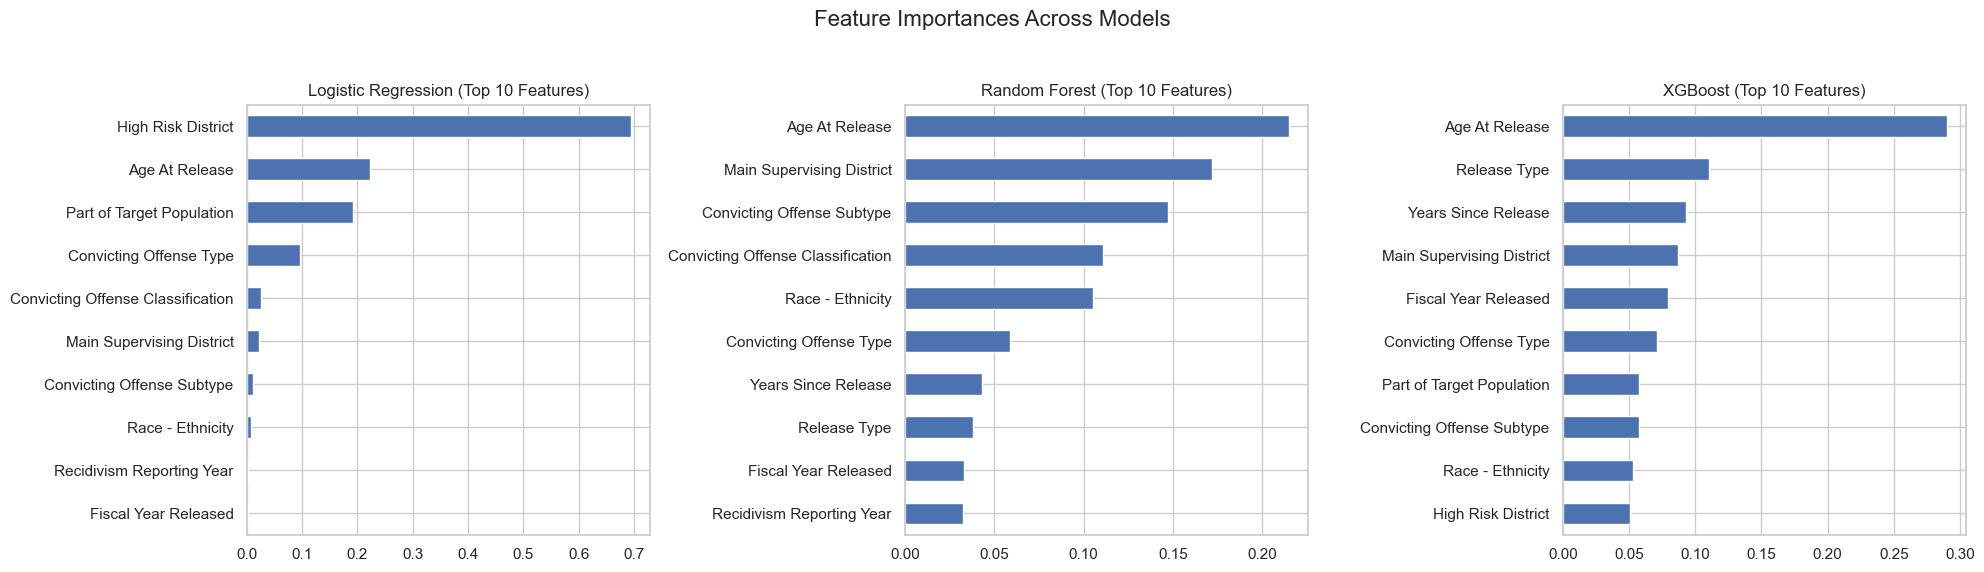

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import plot_importance

# Assume:
# - logreg is your Logistic Regression model
# - rf is your Random Forest model
# - xgb is your XGBoost model
# - X.columns are your feature names

# Logistic Regression "importance" (absolute value of coefficients)
logreg_importances = pd.Series(np.abs(logreg.coef_[0]), index=X.columns)

# Random Forest importance
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# XGBoost importance (manual extraction)
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression
logreg_importances.sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[0])
axes[0].set_title('Logistic Regression (Top 10 Features)')
axes[0].invert_yaxis()

# Random Forest
rf_importances.sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[1])
axes[1].set_title('Random Forest (Top 10 Features)')
axes[1].invert_yaxis()

# XGBoost
xgb_importances.sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[2])
axes[2].set_title('XGBoost (Top 10 Features)')
axes[2].invert_yaxis()

# Layout and show
plt.suptitle('Feature Importances Across Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
